In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso,LinearRegression


# Carregar o dataset
df = pd.read_csv("C:/github/Rio-Housing-Scrapper/Data(29-09_2023)/df_cleaned_final.csv")

# Excluir as colunas "Rent" e "Address"
df = df.drop(columns=["Rent", "Address", "Region"])

# Exibir as primeiras linhas do dataframe
df.head()

,Property Type,Total Rent,Area,Rooms,Bathrooms,Garage,Furnished
0,Apartamento,1368,55,2,1,1.0,0
1,Apartamento,6012,140,5,2,1.0,1
2,Apartamento,3198,53,1,1,0.0,0
3,Apartamento,4075,61,2,1,0.0,0
4,Apartamento,2649,27,1,1,0.0,0


In [2]:
# Definir variáveis independentes (features) e a variável dependente (target)
X = df.drop("Total Rent", axis=1)
y = df["Total Rent"]

# Dividir os dados em conjuntos de treino e teste (75% treino, 25% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Exibir o tamanho dos conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1929, 6), (643, 6), (1929,), (643,))

In [3]:
# Aplicar codificação one-hot à coluna 'Property Type'
X_train = pd.get_dummies(X_train, columns=['Property Type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Property Type'], drop_first=True)

# Treinar o modelo de regressão linear novamente
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Prever valores no conjunto de teste e calcular MSE
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)


MSE: 4222621.87842033


In [4]:
# Treinar o modelo de Regressão Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Prever valores no conjunto de teste e calcular MSE para Regressão Ridge
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Treinar o modelo de Regressão Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

# Prever valores no conjunto de teste e calcular MSE para Regressão Lasso
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

mse_ridge, mse_lasso

(4223666.3499856815, 4224117.062425409)

Tratar agora considerando região

In [5]:
# Carregar o dataset
df = pd.read_csv("C:/github/Rio-Housing-Scrapper/Data(29-09_2023)/df_cleaned_final.csv")

# Excluir as colunas "Rent" e "Address"
df = df.drop(columns=["Rent", "Address"])

# Definir variáveis independentes (features) e a variável dependente (target)
X = df.drop("Total Rent", axis=1)
y = df["Total Rent"]

# Dividir os dados em conjuntos de treino e teste (75% treino, 25% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Exibir o tamanho dos conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1929, 7), (643, 7), (1929,), (643,))

In [6]:
# Agrupar categorias raras em "Outros"

# Contar o número de observações para cada categoria
category_counts = X_train['Region'].value_counts()

# Identificar categorias com menos de 3 observações
small_categories = category_counts[category_counts < 2].index

# Substituir essas categorias por "Outros"
X_train['Region'] = X_train['Region'].replace(small_categories, 'Outros')
X_test['Region'] = X_test['Region'].replace(small_categories, 'Outros')

# Calcular as médias da variável resposta para cada categoria de "Region" usando o conjunto de treino
region_target_mean = y_train.groupby(X_train['Region']).mean()

# Substituir cada categoria em "Region" pela média correspondente no conjunto de treino e teste
X_train['Region'] = X_train['Region'].map(region_target_mean)
X_test['Region'] = X_test['Region'].map(region_target_mean)

# Preencher quaisquer valores NaN no conjunto de teste com a média global do conjunto de treino
X_test['Region'].fillna(y_train.mean(), inplace=True)

# Aplicar codificação one-hot à coluna 'Property Type'
X_train = pd.get_dummies(X_train, columns=['Property Type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Property Type'], drop_first=True)

# Treinar o modelo de regressão linear novamente
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Prever valores no conjunto de teste e calcular MSE
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 2332052.6308864625


Treinando esse mesmo modelo com validação cruzada pelo risco de overfitting

In [7]:
# Função para calcular o MSE usando validação cruzada
def cross_val_mse(model, X, y, n_folds=5):
    kf = KFold(n_splits = n_folds, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Agrupar categorias raras em "Outros" no conjunto de treino do fold
        category_counts = X_train_fold['Region'].value_counts()
        small_categories = category_counts[category_counts < 2].index
        X_train_fold['Region'] = X_train_fold['Region'].replace(small_categories, 'Outros')
        X_test_fold['Region'] = X_test_fold['Region'].replace(small_categories, 'Outros')
        
        # Calcular as médias da variável resposta para cada categoria de "Region" usando o conjunto de treino do fold
        region_target_mean = y_train_fold.groupby(X_train_fold['Region']).mean()
        
        # Substituir cada categoria em "Region" pela média correspondente nos conjuntos de treino e teste do fold
        X_train_fold['Region'] = X_train_fold['Region'].map(region_target_mean)
        X_test_fold['Region'] = X_test_fold['Region'].map(region_target_mean)
        
        # Preencher valores NaN no conjunto de teste com a média global do conjunto de treino
        X_test_fold['Region'].fillna(y_train_fold.mean(), inplace=True)
        
        # Aplicar codificação one-hot à coluna "Property Type"
        X_train_fold = pd.get_dummies(X_train_fold, columns=['Property Type'], drop_first=True)
        X_test_fold = pd.get_dummies(X_test_fold, columns=['Property Type'], drop_first=True)
        
        # Treinar o modelo e calcular MSE
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        mse_scores.append(mse_fold)
    
    # Calcular a média dos MSEs obtidos nos folds
    average_mse = np.mean(mse_scores)
    return average_mse

# Criar modelo
model = LinearRegression()

# Calcular MSE usando validação cruzada
average_mse = cross_val_mse(model, X, y)
print("O MSE com validação cruzada foi de:", average_mse)

O MSE com validação cruzada foi de: 2122669.030072992


C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['Region'] = X_train_fold['Region'].replace(small_categories, 'Outros')
C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['Region'] = X_test_fold['Region'].replace(small_categories, 'Outros')
C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:20: SettingWithCopyWarning: 
A value is trying to b

In [8]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Criar modelos
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Elastic Net": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Linear Regression": LinearRegression()
}

# Calcular MSE usando validação cruzada para cada modelo
mse_scores = {}
for model_name, model in models.items():
    mse = cross_val_mse(model, X, y)
    mse_scores[model_name] = mse

# Exibir os resultados
mse_scores


C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['Region'] = X_train_fold['Region'].replace(small_categories, 'Outros')
C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['Region'] = X_test_fold['Region'].replace(small_categories, 'Outros')
C:\Users\Cliente\AppData\Local\Temp\ipykernel_20440\668577033.py:20: SettingWithCopyWarning: 
A value is trying to b

{'Lasso': 2122972.7657615454,
 'Ridge': 2122798.89779835,
 'Elastic Net': 2240460.1620918093,
 'Decision Tree': 2885736.3402510816,
 'Random Forest': 1815420.360420928,
 'Linear Regression': 2122669.030072992}

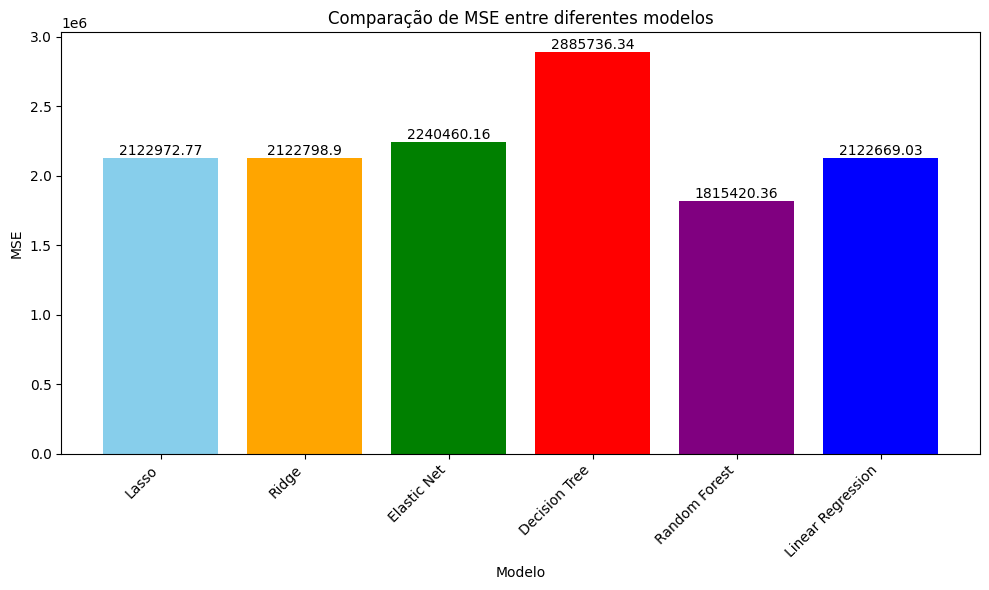

In [9]:
import matplotlib.pyplot as plt

# Criar gráfico de barras com os MSEs
model_names = list(mse_scores.keys())
mse_values = list(mse_scores.values())

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color=['skyblue', 'orange', 'green', 'red', 'purple', 'blue'])
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.title('Comparação de MSE entre diferentes modelos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adicionar os valores de MSE em cima das barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X, y)

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py", line 908, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Casa em condomínio'

--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py", line 908, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Cliente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Apartamento'
